In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None 

### RANDOM FOREST CLASS CREATION

-----


In [2]:
class Random_forest():

    """Apply a Random Forest model and calculate the importance of predictor variables for the model.
    """

    def __init__(self, dataframe, response_variable, parameters):

        """Constructor method.
        Parameters: Dataframe for application of model, response variable, parameters hat we choose for the method.
        """

        self.dataframe = dataframe
        self.response_variable = response_variable
        self.parameters = parameters

    def fit_model(self):

        """Fits a random forest model on the given dataset, dividing it into separate training and testing sets.
        Parameters: None.
        Returns: Model object.
        """

        X = self.dataframe.drop(self.response_variable, axis = 1)
        y = self.dataframe[self.response_variable]

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

        grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state= 42), param_grid= self.parameters, cv=10, verbose= False) 

        grid_search.fit(self.x_train, self.y_train)

        self.my_forest = grid_search.best_estimator_

        self.y_pred_test = self.my_forest.predict(self.x_test)

        self.y_pred_train = self.my_forest.predict(self.x_train)

        return self.my_forest


    def get_metrics(self, model_name):

        """Create a dataframe showing the model's metrics, divided between the train and test sets.
        Parameters: Name of the method we are going to use.
        Returns: Dataframe containing model metrics.
        """
        
        accuracy_test = accuracy_score(self.y_test, self.y_pred_test)
        precision_test = precision_score(self.y_test, self.y_pred_test)
        recall_test = recall_score(self.y_test, self.y_pred_test)
        f1_test = f1_score(self.y_test, self.y_pred_test)
        kappa_test = cohen_kappa_score(self.y_test, self.y_pred_test)

        accuracy_train = accuracy_score(self.y_train, self.y_pred_train)
        precision_train = precision_score(self.y_train, self.y_pred_train)
        recall_train = recall_score(self.y_train, self.y_pred_train)
        f1_train = f1_score(self.y_train, self.y_pred_train)
        kappa_train = cohen_kappa_score(self.y_train, self.y_pred_train)
            
        dataframe = pd.DataFrame({'accuracy': [accuracy_test, accuracy_train], 
                            'precision': [precision_test, precision_train],
                            'recall': [recall_test, recall_train], 
                            'f1': [f1_test, f1_train],
                            'kappa': [kappa_test, kappa_train],
                            'set': ['test', 'train']})
        
        dataframe['model'] = model_name

        return dataframe


    def create_df_feature_importance(self):

        """Create a dataframe showing the importance of the features for the model.
        Parameters: None
        Returns: Dataframe containing model the importance of the features.
        """

        self.predictors_sig_dataframe = pd.DataFrame({'predictor': self.x_train.columns, 'importance': self.my_forest.feature_importances_})

        self.predictors_sig_dataframe.sort_values(by=['importance'], ascending=False, inplace = True)

        return self.predictors_sig_dataframe
        

    def create_barplot_feature_importance(self, title_dataframe):

        """Create a barplot showing the importance of the features for the model.
        Parameters: Title of the dataframe we are using.
        Returns: None
        """

        my_barplot_palette = LinearSegmentedColormap.from_list('Gradient', ['teal', 'mediumturquoise', 'paleturquoise'])
        num_bars = (len(self.dataframe.columns) -1)

        plt.figure(figsize=(10,6))
        sns.barplot(x = 'importance', y = 'predictor', data = self.predictors_sig_dataframe, palette= my_barplot_palette(np.linspace(0, 1, num_bars)))
        plt.title(f'{title_dataframe.upper()} RANDOM FOREST FEATURE IMPORTANCE', fontsize = 12, color = 'darkslategray', fontweight = 'bold')
        plt.show()


### RANDOM FOREST ON RANDOM_OVER_SAMPLE DATAFRAME

-----


In [3]:
df_over = pd.read_pickle('../data/generated_data/cardio_processed_over.pkl')
df_over.head()

,age_category,BMI_category,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,education_1.0,education_2.0,education_3.0,education_4.0,sex_F,sex_M,is_smoking_NO,is_smoking_YES,TenYearCHD
0,2.0,0.25,0,0,0,0,1.071429,0.15,-0.224138,0.722222,0.450931,1.000000,0.142857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,0.5,0.25,0,0,1,0,-0.928571,0.00,-0.379310,1.462963,0.883744,-0.200000,-0.214286,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
2,0.5,0.00,0,0,0,0,-0.214286,0.50,0.275862,-0.462963,-1.012582,0.866667,1.142857,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,0.5,0.25,0,0,1,0,0.071429,1.00,-0.017241,1.092593,0.579768,-0.466667,1.142857,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
4,2.0,0.25,0,0,0,0,1.071429,1.50,0.120690,0.296296,0.209361,-0.333333,-0.071429,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [4]:
response_var = 'TenYearCHD'

In [5]:
param_over = {"max_depth": [9, 10, 11, 12], 
        "max_features": [2, 3, 4, 5],
        "min_samples_split": [50, 100, 150],
        "min_samples_leaf": [10, 20, 50]} 

In [6]:
random_forest_over = Random_forest(df_over, response_var, param_over)

In [7]:
random_forest_pred = random_forest_over.fit_model()

In [22]:
with open ('../data/predict_objects/random_forest_pred.pkl','wb') as rf:
    pickle.dump(random_forest_pred, rf)

In [9]:
rf_over_results = random_forest_over.get_metrics('OVER Random Forest')
rf_over_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.786458,0.757906,0.825416,0.790222,0.573583,test,OVER Random Forest
1,0.828784,0.812819,0.859107,0.835322,0.657312,train,OVER Random Forest


In [10]:
random_forest_over.create_df_feature_importance()

,predictor,importance
6,age,0.210059
9,sysBP,0.172459
12,glucose,0.101890
8,totChol,0.097216
10,BMI,0.088848
11,heartRate,0.074829
7,cigsPerDay,0.053699
4,prevalentHyp,0.050214
0,age_category,0.041999
18,sex_M,0.016712


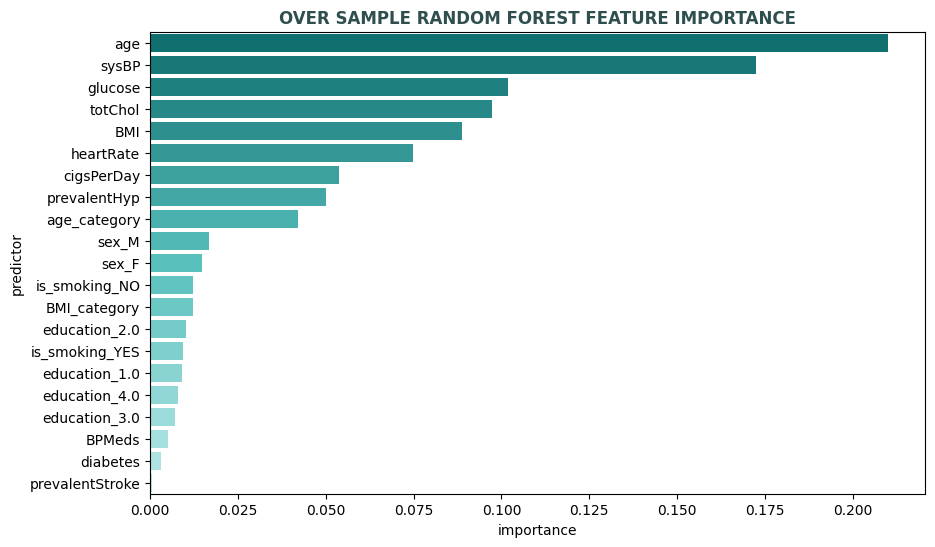

In [11]:
random_forest_over.create_barplot_feature_importance('OVER SAMPLE')

### RANDOM FOREST ON TOKEN_SMOTE DATAFRAME

-----


In [12]:
df_ts = pd.read_pickle('../data/generated_data/cardio_processed_ts.pkl')
df_ts.head()

,age_category,BMI_category,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,TenYearCHD,education_1.0,education_2.0,education_3.0,education_4.0,sex_F,sex_M,is_smoking_NO,is_smoking_YES
0,2.0,0.25,0,0,0,0,1.071429,0.15,-0.224138,0.722222,0.450931,1.000000,0.142857,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.5,0.25,0,0,1,0,-0.928571,0.00,-0.379310,1.462963,0.883744,-0.200000,-0.214286,0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.5,0.00,0,0,0,0,-0.214286,0.50,0.275862,-0.462963,-1.012582,0.866667,1.142857,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.5,0.25,0,0,1,0,0.071429,1.00,-0.017241,1.092593,0.579768,-0.466667,1.142857,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2.0,0.25,0,0,0,0,1.071429,1.50,0.120690,0.296296,0.209361,-0.333333,-0.071429,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [13]:
param_ts = {"max_depth": [10, 11, 12], 
        "max_features": [3, 4, 5],
        "min_samples_split": [50, 100, 150],
        "min_samples_leaf": [10, 20, 50]} 

In [14]:
random_forest_ts = Random_forest(df_ts, response_var, param_over)

In [15]:
random_forest_ts.fit_model()

RandomForestClassifier(max_depth=9, max_features=2, min_samples_leaf=10,
                       min_samples_split=50, random_state=42)

In [16]:
rf_ts_results = random_forest_ts.get_metrics('TS Random Forest')
rf_ts_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.853491,0.0,0.0,0.0,0.0,test,TS Random Forest
1,0.847450,0.0,0.0,0.0,0.0,train,TS Random Forest


In [17]:
random_forest_ts.create_df_feature_importance()

,predictor,importance
6,age,0.181663
9,sysBP,0.148618
12,glucose,0.095049
0,age_category,0.082176
10,BMI,0.079724
8,totChol,0.077259
4,prevalentHyp,0.056562
11,heartRate,0.056200
7,cigsPerDay,0.048438
18,sex_M,0.031238


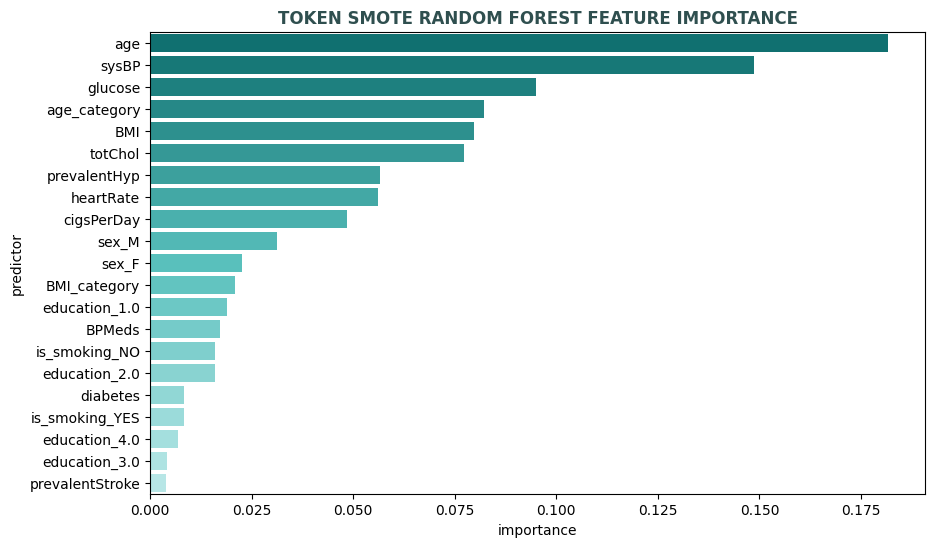

In [18]:
random_forest_ts.create_barplot_feature_importance('TOKEN SMOTE')

### SAVE RESULTS

-----


In [19]:
lr_dt_results = pd.read_pickle('../data/generated_data/LR_DT_results.pkl')

In [20]:
all_results = pd.concat([lr_dt_results, rf_over_results, rf_ts_results], axis = 0)
all_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.696181,0.686690,0.692399,0.689533,0.392092,test,OVER Logistic Regression
1,0.676427,0.673614,0.698085,0.685632,0.352517,train,OVER Logistic Regression
0,0.860374,0.684211,0.087248,0.154762,0.125791,test,TS Logistic Regression
1,0.856300,0.744186,0.088398,0.158025,0.129837,train,TS Logistic Regression
0,0.718750,0.690171,0.767221,0.726659,0.438691,test,OVER Decision Tree Best
1,0.763772,0.742729,0.814924,0.777154,0.526980,train,OVER Decision Tree Best
0,0.852507,0.473684,0.060403,0.107143,0.076540,test,TS Decision Tree Best
1,0.853772,0.631579,0.099448,0.171838,0.135976,train,TS Decision Tree Best
0,0.786458,0.757906,0.825416,0.790222,0.573583,test,OVER Random Forest
1,0.828784,0.812819,0.859107,0.835322,0.657312,train,OVER Random Forest


Using the Random Forest technique on the Over_Sample Dataframe, we attained the most satisfactory metrics thus far. The metrics are satisfactory, although the kappa score could be improved. Nonetheless, we could not achieve an acceptable outcome in the Token_Smote Dataframe despite our best efforts to adjust the model, hence we disregard this result. Although we are satisfied with the results of the first dataframe, we will try a different model.

In [21]:
all_results.to_pickle('../data/generated_data/LR_DT_RF_results.pkl')